Robert Siipola <br>
Student number 2508568 <br>
February, 02, 2026  <br>

# Exercise 1 | TKO_7092 Evaluation of Machine Learning Methods 2026

### Case study: Metal ion concentration prediction (video lectures, slides and scripts in MOOC2) 

#### Prediction of the metal ion content from multi-parameter data
<b> Use K-Nearest Neighbor Regression with euclidean distance to predict total metal concentration (c_total), concentration of Cadmium (Cd) and concentration of Lead (Pb), using number of neighbors k = 1, 3, 5, 7.</b>

    - Please use Nearest Neighbor Regression from https://scikit-learn.org/stable/modules/neighbors.html   
    - Implement Leave-One-Out cross-validation and calculate the C-index for each output (c_total, Cd, Pb). 
    - Implement Leave-Replicas-Out cross-validation and calculate the C-index for each output (c_total, Cd, Pb).
    - Return your solution as a Jupyter Notebook (.ipynb) and as a PDF file generated from it. Please, add your full name to the file name.
    - Make sure that the code is runnable as is.
    - If AI was used, please explain at the end of the notebook, in the "AI usage disclaimer" section, how and in which parts it was applied.
    - The exercise will be graded as pass/fail.
    - Submit to moodle your solution on ** Wednesday 4 of February ** at the latest.
  
<b>Please be aware that you are required to submit your individual solution.<br> 
Submissions with identical or similar code will result in a failure for the exercise.</b>

## Import libraries

In [29]:
# In this cell import all libraries you need. For example: 
import os
import numpy as np
import pandas as pd
from scipy.stats import somersd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import LeaveOneOut, LeaveOneGroupOut, LeavePOut, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

## Read and visualize the dataset

<p> <b>Note:</b> This dataset differs slightly from the one used in the video lectures. <br>
<b>In this dataset, some mixtures have 3 replicas, while others have 4 replicas. </b> </p> 

In the following cell: 
- Read the file water_data.csv
- Print the dimesions of the dataset (i.e. number of rows and columns) and display the first 5 rows.
- Identify the inputs and the outputs columns.
- Provide the number of mixtures with 3 replicas and 4 replicas, respectively.

In [30]:
sns.set_style("whitegrid")

path = '../data/water_data.csv'
assert os.path.exists(path)
df = pd.read_csv(path)
print(df.shape)
print(df.head())
rep_counts = df.groupby(["c_total", "Cd", "Pb"]).size().value_counts().sort_index()
print("\nReplicates per mixture (count -> how many mixtures):")
print(rep_counts.to_string())
# inputs
X = df[["Mod1", "Mod2", "Mod3"]].to_numpy()
# outputs
Y = df[["c_total", "Cd", "Pb"]].to_numpy()

ks = [1, 3, 5, 7]

(243, 6)
       Mod1      Mod2      Mod3  c_total      Cd      Pb
0 -0.994673 -0.662192  0.327797     14.0     2.8    11.2
1 -0.982196 -0.662465  0.976950     14.0     0.0    14.0
2  2.063228  2.552820  1.681019    200.0   200.0     0.0
3 -0.839376 -0.586206 -1.471322   5000.0  3000.0  2000.0
4 -0.846858 -0.543135 -1.404644   5000.0  4000.0  1000.0

Replicates per mixture (count -> how many mixtures):
3    25
4    42


## C-index code 

In [20]:
# In this cell is the fuction that computes the c-index value based on Somers'D statistic.
# Use this fuction as the evaluation metric in the Leave-One-Out (LOOCV) and Leave-Replicas-Out (LROCV) cross-validation methods.

def cindex(true, pred):
    s_d = somersd(true, y=pred, alternative='two-sided')
    c_index = (s_d.statistic + 1.0)/2.0
    return c_index

## Leave-One-Out cross-validation

In [21]:
# Here add your code for Leave-One-Out cross-validation and print the corresponding results.
def predict_loocv(k: int) -> np.ndarray:
    loo = LeaveOneOut()
    model = KNeighborsRegressor(n_neighbors=k, metric='euclidean', weights='uniform')
    Y_pred = cross_val_predict(model, X, Y, cv=loo)
    return Y_pred

rows = []
for k in ks:
    pred_loo = predict_loocv(k)

    rows.append({
        "CV": "LOOCV", "k": k,
        "c_total": cindex(Y[:, 0], pred_loo[:, 0]),
        "Cd": cindex(Y[:, 1], pred_loo[:, 1]),
        "Pb": cindex(Y[:, 2], pred_loo[:, 2]),
    })

loocv_results = pd.DataFrame(rows).sort_values(["CV", "k"])
print(loocv_results)

      CV  k   c_total        Cd        Pb
0  LOOCV  1  0.912184  0.919378  0.883584
1  LOOCV  3  0.910789  0.903003  0.877198
2  LOOCV  5  0.891159  0.855846  0.850783
3  LOOCV  7  0.878592  0.824169  0.829808


In [24]:
groups = df[["c_total", "Cd", "Pb"]].astype(str).agg("|".join, axis=1).to_numpy()

def predict_lrocv(k: int) -> np.ndarray:
    lro = LeaveOneGroupOut()
    model = KNeighborsRegressor(n_neighbors=k, metric='euclidean', weights='uniform')
    Y_pred = cross_val_predict(model, X, Y, cv=lro, groups=groups, method="predict")
    return Y_pred


rows = []
for k in ks:
    pred_loo = predict_lrocv(k)

    rows.append({
        "CV": "LOOCV", "k": k,
        "c_total": cindex(Y[:, 0], pred_loo[:, 0]),
        "Cd": cindex(Y[:, 1], pred_loo[:, 1]),
        "Pb": cindex(Y[:, 2], pred_loo[:, 2]),
    })

results = pd.DataFrame(rows).sort_values(["CV", "k"])
print(results)

      CV  k   c_total        Cd        Pb
0  LOOCV  1  0.821765  0.755345  0.753416
1  LOOCV  3  0.810146  0.759260  0.755074
2  LOOCV  5  0.813251  0.742653  0.746424
3  LOOCV  7  0.815760  0.741169  0.748332


## Leave-Replicas-Out cross-validation

In [12]:
# Here add your code for Leave-Replicas-Out cross-validation and print the corresponding results.

groups = df[["c_total", "Cd", "Pb"]].astype(str).agg("|".join, axis=1).to_numpy()

def predict_lrocv(k: int) -> np.ndarray:
    lro = LeaveOneGroupOut()
    model = KNeighborsRegressor(n_neighbors=k, metric='euclidean', weights='uniform')
    Y_pred = cross_val_predict(model, X, Y, cv=lro, groups=groups, method="predict")
    return Y_pred 


rows = []
for k in ks:
    pred_lro = predict_lrocv(k)

    rows.append({
        "CV": "LROCV", "k": k,
        "c_total": cindex(Y[:, 0], pred_lro[:, 0]),
        "Cd": cindex(Y[:, 1], pred_lro[:, 1]),
        "Pb": cindex(Y[:, 2], pred_lro[:, 2]),
    })

lro_results = pd.DataFrame(rows).sort_values(["CV", "k"])
print(lro_results)

      CV  k   c_total        Cd        Pb
0  LROCV  1  0.821765  0.755345  0.753416
1  LROCV  3  0.810146  0.759260  0.755074
2  LROCV  5  0.813251  0.742653  0.746424
3  LROCV  7  0.815760  0.741169  0.748332


## Compare Leave-One-Out and Leave-Replicas-Out Results

Plot the results as they were presented in the video lecture (refer to MOOC2-Module 2 .pptx slides).

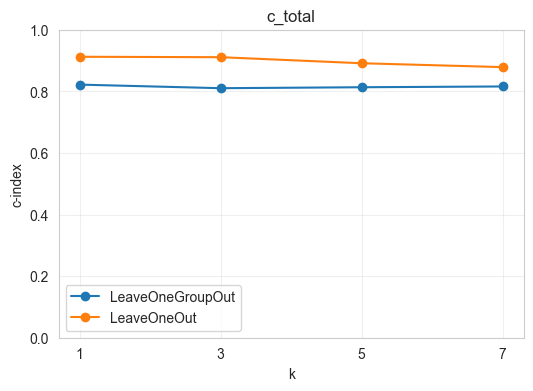

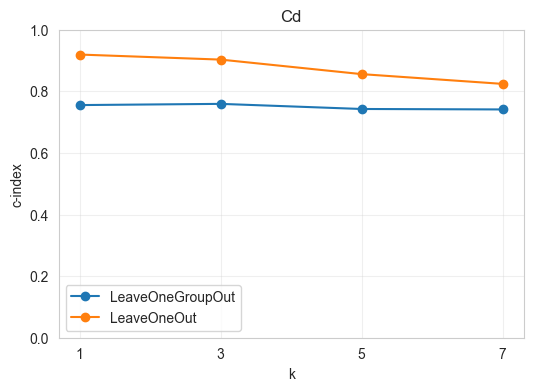

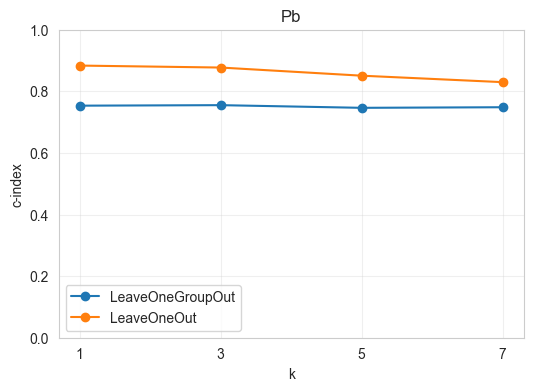

In [28]:
results = results.copy()
loocv_results = loocv_results.copy()

results["CV"] = "LeaveOneGroupOut" 
loocv_results["CV"] = "LeaveOneOut"

targets = ["c_total", "Cd", "Pb"]

long1 = results.melt(id_vars=["CV", "k"], value_vars=targets,
                     var_name="target", value_name="cindex")
long2 = loocv_results.melt(id_vars=["CV", "k"], value_vars=targets,
                           var_name="target", value_name="cindex")

long = pd.concat([long1, long2], ignore_index=True)


for t in targets:
    fig, ax = plt.subplots(figsize=(6, 4))

    for cv_name, sub in long[long["target"] == t].groupby("CV"):
        sub = sub.sort_values("k")
        ax.plot(sub["k"], sub["cindex"], marker="o", label=cv_name)

    ax.set_title(t)
    ax.set_ylim(bottom=0, top=1)
    ax.set_xlabel("k")
    ax.set_ylabel("c-index")
    ax.set_xticks([1, 3, 5, 7])
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.show()

## Interpretation of results
#### Answer the following questions based on the results obtained
1. Which cross-validation approach produced more optimistic results, and why?
2. Which cross-validation method provides a better estimate of the model's performance on unseen mixtures? Explain your answer.

#### Answers:

1. Leave-One-Out Cross Validation (LOOCV) produces more optimistic results, because it's re-using the replica data or more generally leaking information.
2. Due to the data information leakage affecting the model performance for LOOCV, Leave-Group-Out Cross Validation would likely perform better on unseed mixtures.

## AI usage disclaimer

# In case AI was used to solve the exercise, please explain how and in which parts it was used.
Used Cursor's autocomplete feature to generate some of the code. Sparred with ChatGPT about the results and their meaning.